# Siamese networks

## Colab preparation

In [ ]:
# to install pytorch on colab
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms


# 1. Setup and initializations
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (`32 conv 5x5 -> ReLU -> MaxPool 2x2 -> 64 conv 5x5 -> ReLU -> MaxPool 2x2 -> Fully Connected 256 -> ReLU -> Fully Connected 256 -> ReLU -> Fully Connected 2`) with the same hyperparameters.

In [3]:
class ExperimentParams():
    def __init__(self):
        self.num_classes = 10
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.batch_size = 256
        self.lr = 1e-2
        self.num_epochs = 10
        self.num_workers = 4
        self.data_dir = '/home/docker_user/'
        

args = ExperimentParams()

## 1.1 Prepare dataset
We'll be working on MNIST dataset

In [4]:

mean, std = 0.1307, 0.3081

train_dataset = MNIST(f'{args.data_dir}/data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST(f'{args.data_dir}/data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

## 1.2 Common setup

In [5]:

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, title='',xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)
    plt.title(title)

def extract_embeddings(dataloader, model, args):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.to(args.device)
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels


def get_raw_images(dataloader,mean=0.1307, std=0.3081):

    raw_images = np.zeros((len(dataloader.dataset), 1, 28, 28))
    k = 0
    for input, target in dataloader:
        raw_images[k:k+len(input)] = (input*std + mean).data.cpu().numpy()
        k += len(input)

    return raw_images


def show(img, title=None):
    # img is a torch.Tensor     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# 2. Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings. 

We will define our base embedding architecture which will serve as common backbone for our experiments

## 2.1 Architecture

#### Exercise

Complete the missing blocks in the definition of the following `EmbeddingNet` architecture: (`32 conv 5x5 -> ReLU -> MaxPool 2x2 -> 64 conv 5x5 -> ReLU -> MaxPool 2x2 -> Fully Connected 256 -> ReLU -> Fully Connected 256 -> ReLU -> Fully Connected 2`)

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, ...)
#         self.conv2 = ...
#         self.fc1 = ...
#         self.fc2 = ...
#         self.fc3 = ...

    def forward(self, x, debug=False):
        x1 = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)
#         output = ...                  
        if debug == True:
            print(f'input: {x.size()}')
            print(f'x1: {x1.size()}')
                      
        return output

    def get_embedding(self, x):
        return self.forward(x)
    


If you want to better check the sizes of the hidden states and do debugging, you can add a `debug` variable in the `forward` function just like above

In [129]:
input = torch.zeros(1, 1, 28, 28)
net = EmbeddingNet()
net(input,debug=True)

input: torch.Size([1, 1, 28, 28])
x1: torch.Size([1, 32, 12, 12])
x2: torch.Size([1, 64, 4, 4])
x3: torch.Size([1, 1024])
x4: torch.Size([1, 256])
x5: torch.Size([1, 256])
output: torch.Size([1, 2])


tensor([[ 0.0220, -0.0461]], grad_fn=<AddmmBackward>)

Now let's define a classification net that will add fully connected layer on top of `EmbeddingNet`

#### Exercice

Fill in the missing spots in the `forward` pass:

In [41]:
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, num_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.prelu = nn.PReLU()
        self.fc = nn.Linear(2, num_classes)

    def forward(self, x, debug=False):
        embedding = None
        output = self.fc(self.prelu(embedding))
        
        if debug == True:
            print(f'input: {x.size()}')
            print(f'embedding: {embedding.size()}')
            print(f'output: {output.size()}')
            
        return output
    
    def get_embedding(self, x):
        return self.prelu(None)


## 2.2 Training

In [14]:
# Set up data loaders

kwargs = {'num_workers': args.num_workers, 'pin_memory': True} 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, **kwargs)

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, num_classes=args.num_classes)
loss_fn = torch.nn.CrossEntropyLoss()
model.to(args.device)
loss_fn.to(args.device)

optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

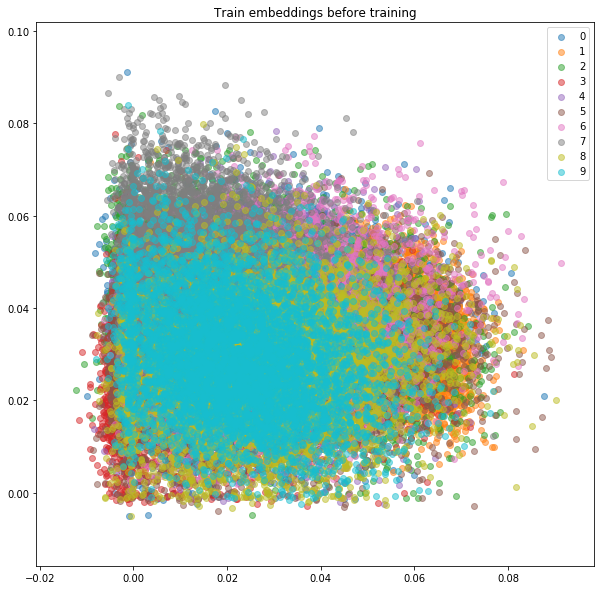

In [15]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model, args)
plot_embeddings(train_embeddings_baseline, train_labels_baseline, 'Train embeddings before training')

In [126]:
def train_classif_epoch(train_loader, model, loss_fn, optimizer, args, log_interval=50):
    model.train()
    losses = []
    total_loss, total_corrects, num_samples = 0, 0, 0
    corrects = 0    
    for batch_idx, (data, target) in enumerate(train_loader):
        num_samples += data.size(0)
        
        data, target = data.to(args.device), target.to(args.device)
        
        optimizer.zero_grad()
        outputs = model(data)

        loss = loss_fn(outputs, target)
        losses.append(loss.data.item())

        _,preds = torch.max(outputs.data,1)
        corrects += torch.sum(preds == target.data).cpu()

        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAccuracy: {}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses), float(total_corrects)/num_samples))           
            
            total_loss += np.sum(losses)
            total_corrects += corrects
            losses, corrects = [], 0

    return total_loss/(batch_idx + 1), total_corrects/num_samples

def test_classif_epoch(test_loader, model, loss_fn, args, log_interval=50):
    with torch.no_grad():
        model.eval()
        losses, corrects = [], 0
        num_samples = 0
    
        for batch_idx, (data, target) in enumerate(test_loader):

            num_samples += data.size(0)
            data, target = data.to(args.device), target.to(args.device)

            outputs = model(data)

            loss = loss_fn(outputs, target)
            losses.append(loss.data.item())

            _,preds = torch.max(outputs.data,1)
            corrects += torch.sum(preds == target.data).cpu()

        return np.sum(losses)/(batch_idx + 1), corrects/num_samples

In [127]:
start_epoch = 0

for epoch in range(0, start_epoch):
    scheduler.step()

for epoch in range(start_epoch, args.num_epochs):
    scheduler.step()

    train_loss, train_accuracy = train_classif_epoch(train_loader, model, loss_fn, optimizer, args)

    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f} Average accuracy: {:.4f}'.format(
        epoch + 1, args.num_epochs, train_loss, train_accuracy)
    
    val_loss, val_accuracy = test_classif_epoch(test_loader, model, loss_fn, args)
    
    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}  Average accuracy: {:.4f}'.format(epoch + 1, args.num_epochs,
                                                                             val_loss, val_accuracy)
    print(message)


Train: [0/60000 (0%)]	Loss: 2.295478 	Accuracy: 0.0
Train: [50/60000 (11%)]	Loss: 1.764369 	Accuracy: 0.0026041666666666665
Train: [100/60000 (21%)]	Loss: 1.286137 	Accuracy: 0.15957611386138615
Train: [150/60000 (32%)]	Loss: 0.986622 	Accuracy: 0.24508485099337748
Train: [200/60000 (43%)]	Loss: 0.737489 	Accuracy: 0.32256685323383083
Train: [250/60000 (53%)]	Loss: 0.579674 	Accuracy: 0.39604083665338646
Train: [300/60000 (64%)]	Loss: 0.476008 	Accuracy: 0.4616642441860465
Train: [350/60000 (75%)]	Loss: 0.403727 	Accuracy: 0.5200765669515669
Train: [400/60000 (85%)]	Loss: 0.265466 	Accuracy: 0.568403210723192
Train: [450/60000 (96%)]	Loss: 0.302536 	Accuracy: 0.6098946784922394
Epoch: 1/10. Train set: Average loss: 0.7301 Average accuracy: 0.0000
Epoch: 1/10. Validation set: Average loss: 0.2303  Average accuracy: 0.0000
Train: [0/60000 (0%)]	Loss: 0.341920 	Accuracy: 0.0
Train: [50/60000 (11%)]	Loss: 0.233975 	Accuracy: 0.01838235294117647
Train: [100/60000 (21%)]	Loss: 0.194887 	Accu

## 2.3 Visualizations

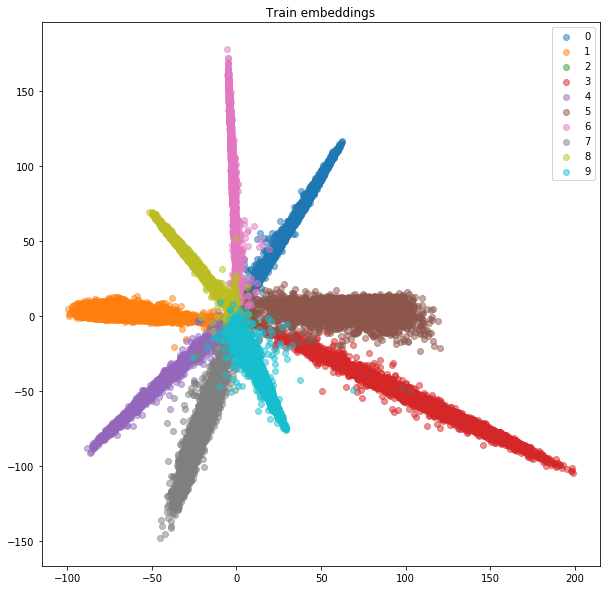

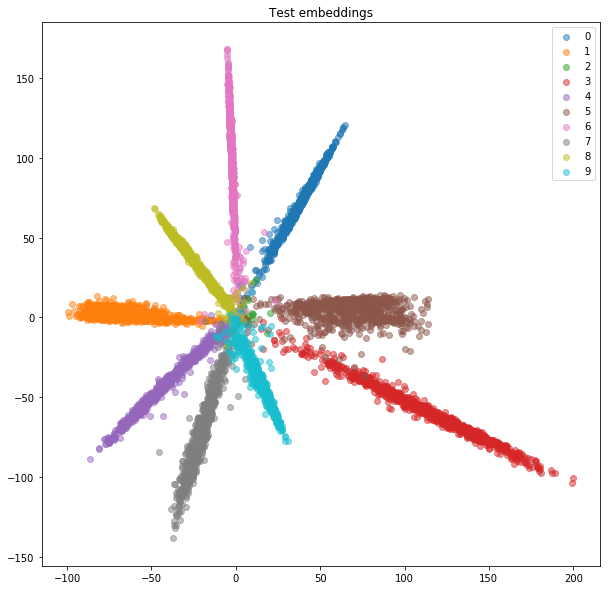

In [25]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model, args)
plot_embeddings(train_embeddings_baseline, train_labels_baseline, 'Train embeddings classification')
test_embeddings_baseline, test_labels_baseline = extract_embeddings(test_loader, model, args)
plot_embeddings(test_embeddings_baseline, test_labels_baseline, 'Test embeddings classification')

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# 3. Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

## 3.1 Architecture
We will first define the siamese architecture on top of our `EmbeddingNet`

#### Exercise

Fill in the forward part of `SiameseNet`

In [16]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        # fill in the missing 2 lines :)
        
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

## 3.2 Data loader
We will also need to adapt our data loader to fetch pairs of images 

In [19]:
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
from PIL import Image

class SiameseMNIST(Dataset):
    """
    train mode: For each sample creates randomly a positive or a negative pair
    test mode: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(self.test_labels.numpy())
            '''
            create a dictionary with an entry key for each label and the value an array storing
            the indices of the images having the respective label
            '''
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(42)
            # itereate through test_data and randomly select samples with the same label
            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            # itereate through test_data, create a list of all labels different from current one and then
            # randomly select samples with having one of these labels
            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            # format: [index1, index2, label(0/1)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        
        # at train time pairs of samples are fetched randomly on the fly
        if self.train:
            # select random label,i.e. similar (1) or non-similar (0) images
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                # select an image with the same label as img1
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                # eliminate label1 from the set of possible labels to select
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                # randomly select an image having a label from this subset
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), target

    def __len__(self):
        return len(self.mnist_dataset)

## 3.3 Loss function

$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

#### Exercise

Fill in the missing parts of the `contrastive loss`

In [90]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        # compute squared distances between output2 and output1  
        squared_distances = None
        # add the second term from them loss. You can use ReLU for compressing the max formula
        losses = 0.5 * (target.float() * squared_distances +
                         None )
        
        return losses.mean() if size_average else losses.sum()
        


## 3.4 Training

In [92]:
# Set up data loaders
siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)

args.batch_size = 128
kwargs = {'num_workers': args.num_workers, 'pin_memory': True}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=args.batch_size, shuffle=False, **kwargs)

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
loss_fn = ContrastiveLoss(margin)
model.to(args.device)
loss_fn.to(args.device)

args.lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

In [93]:
def train_siamese_epoch(train_loader, model, loss_fn, optimizer, args, log_interval=100):
    model.train()
    losses = []
    total_loss, num_samples =  0, 0
  
    for batch_idx, (data, target) in enumerate(train_loader):
        num_samples += data[0].size(0)
        
        data = tuple(d.to(args.device) for d in data)
        target = target.to(args.device)
          
        optimizer.zero_grad()
        
        outputs = model(data[0], data[1])
        # alternatively: outputs = model(*data)
        
        loss = loss_fn(outputs[0], outputs[1], target)
        # alternatively: loss = loss_fn(*outputs, target)
        
        losses.append(loss.data.item())

        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses)))           
            
            total_loss += np.sum(losses)
            losses = []
            
    return total_loss/(batch_idx + 1)

def test_siamese_epoch(test_loader, model, loss_fn, args, log_interval=50):
    with torch.no_grad():
        model.eval()
        losses = []
        num_samples = 0
    
        for batch_idx, (data, target) in enumerate(test_loader):

            num_samples += data[0].size(0)
            data = tuple(d.to(args.device) for d in data)
            target = target.to(args.device)
            outputs = model(data[0], data[1])

            loss = loss_fn(outputs[0], outputs[1], target)
            losses.append(loss.data.item())
    
        return np.sum(losses)/(batch_idx + 1)

In [94]:
start_epoch = 0

# needed for annealing learning rate in case of resuming of training
for epoch in range(0, start_epoch):
    scheduler.step()

# main training loop
for epoch in range(start_epoch, args.num_epochs):
    scheduler.step()

    # train stage
    train_loss = train_siamese_epoch(siamese_train_loader, model, loss_fn, optimizer, args)
    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(
        epoch + 1, args.num_epochs, train_loss)
    
    # testing/validation stage    
    test_loss = test_siamese_epoch(siamese_test_loader, model, loss_fn, args)
    
    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, args.num_epochs,
                                                                             test_loss)
    print(message)

Train: [0/60000 (0%)]	Loss: 0.256609 
Train: [12800/60000 (21%)]	Loss: 0.073147 
Train: [25600/60000 (43%)]	Loss: 0.048552 
Train: [38400/60000 (64%)]	Loss: 0.035012 
Train: [51200/60000 (85%)]	Loss: 0.026525 
Epoch: 1/10. Train set: Average loss: 0.0396
Epoch: 1/10. Validation set: Average loss: 0.0211
Train: [0/60000 (0%)]	Loss: 0.019049 
Train: [12800/60000 (21%)]	Loss: 0.019374 
Train: [25600/60000 (43%)]	Loss: 0.017856 
Train: [38400/60000 (64%)]	Loss: 0.014852 
Train: [51200/60000 (85%)]	Loss: 0.013036 
Epoch: 2/10. Train set: Average loss: 0.0139
Epoch: 2/10. Validation set: Average loss: 0.0131
Train: [0/60000 (0%)]	Loss: 0.010717 
Train: [12800/60000 (21%)]	Loss: 0.012018 
Train: [25600/60000 (43%)]	Loss: 0.011463 
Train: [38400/60000 (64%)]	Loss: 0.010290 
Train: [51200/60000 (85%)]	Loss: 0.009678 
Epoch: 3/10. Train set: Average loss: 0.0093
Epoch: 3/10. Validation set: Average loss: 0.0099
Train: [0/60000 (0%)]	Loss: 0.013019 
Train: [12800/60000 (21%)]	Loss: 0.007945 
Trai

## 3.5 Visualizations

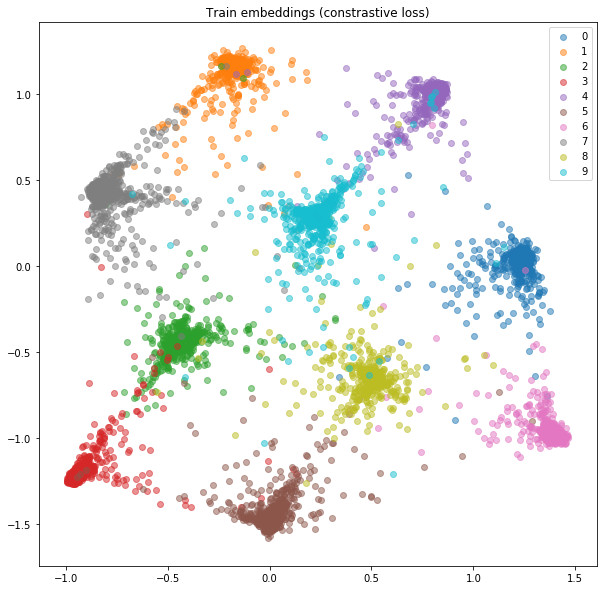

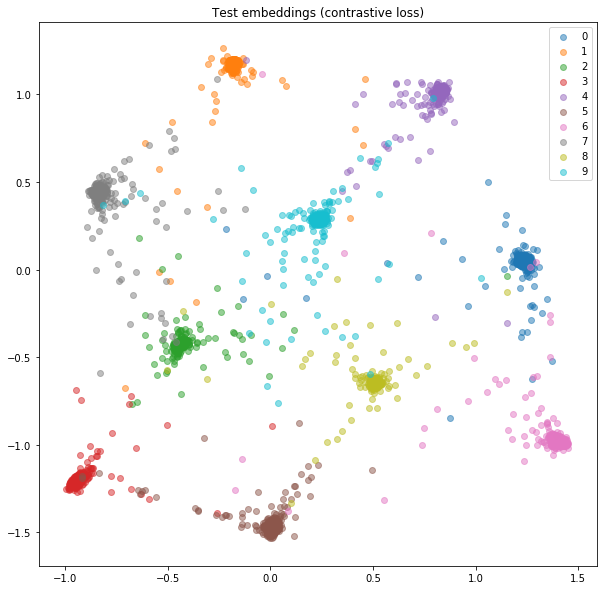

In [33]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model, args)
plot_embeddings(train_embeddings_cl, train_labels_cl, title='Train embeddings (constrastive loss)')
test_embeddings_cl, test_labels_cl = extract_embeddings(test_loader, model, args)
plot_embeddings(test_embeddings_cl, test_labels_cl, title='Test embeddings (contrastive loss)')

In order to two compare vectors $x_1$ and $x_2$ we can use the `cosine similarity` 

$$\text{similarity}=\frac{x_1 \cdot x_2}{\max(\Vert x_1 \Vert _2 \cdot \Vert x_2 \Vert_2, \epsilon)}$$

An alternative is the Euclidean distance.

In order to save computation at query time we can pre-process our vectors and L2-normalize them. Now we can simply perform comparison by dot product

#### Exercise
Perform L2-normalization on the embeddings using `numpy` 

In [131]:
# L2-normalize embeddings
test_embeddings_norm = ....

#### Exercise
Write now a function `most_sim` that computes all dot products between a query vector and the dataset, extracts the indices of the `topk` most similar vectors and put thme in a list of tuples (

In [33]:
def most_sim(x, emb, topk=6):
       return None

In [35]:
test_images_raw = get_raw_images(test_loader)

In [36]:
def launch_query(test_embeddings_norm, test_images_raw, query_id=None):
    query_id = random.randint(0, test_embeddings_norm.shape[0]) if query_id is None else query_id
    query_vector = test_embeddings_norm[query_id,:]

    print(f'query_id: {query_id} | query_embedding: {query_vector}')
    knns = most_sim(query_vector, test_embeddings_norm)
    knn_images = np.array([test_images_raw[x[0]] for x in knns ])
    
    title=['q: 1.0', f'1nn: {knns[1][1]:.3}', f'2nn: {knns[2][1]:.3}', 
           f'3nn: {knns[3][1]:.3}', f'4nn: {knns[4][1]:.3}', f'5nn: {knns[5][1]:.3}']
    show(torchvision.utils.make_grid(torch.from_numpy(knn_images)), title=title)
#     print(knns)
    

query_id: 5823 | query_embedding: [0.92202512 0.38713006]


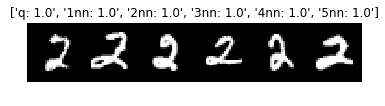

query_id: 1490 | query_embedding: [ 0.8016039  -0.59785549]


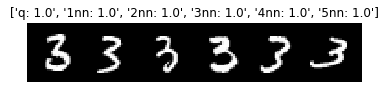

query_id: 4459 | query_embedding: [0.51714034 0.85590062]


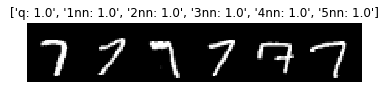

query_id: 2793 | query_embedding: [-0.21095163 -0.9774965 ]


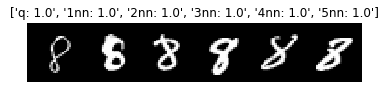

query_id: 754 | query_embedding: [0.88622119 0.46326236]


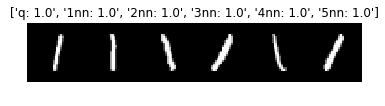

In [102]:
for i in range(5):
    launch_query(test_embeddings_norm, test_images_raw)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

## 4.1 Architecture
We will first define the triplet architecture on top of our `EmbeddingNet`

#### Exercise

Fill in the forward part of `TripleNet`

In [133]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        # missing 3 lines here
        
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

## 4.2 Data loader
We will also need to adapt our data loader to fetch triplets of images 

In [20]:
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
from PIL import Image

class TripletMNIST(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        img3 = Image.fromarray(img3.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3), []

    def __len__(self):
        return len(self.mnist_dataset)

## 4.3 Loss function

#### Exercise

Fill in the missing parts of the `triplet loss`:
 $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [137]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = None # fill in code
        distance_negative = None  # fill in code
        # you can again use ReLU instead of max         
        losses = None # fill in code
        return losses.mean() if size_average else losses.sum()

## 4.4 Training

In [22]:
triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)

args.batch_size = 128
kwargs = {'num_workers': args.num_workers, 'pin_memory': True} 
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=args.batch_size, shuffle=False, **kwargs)

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
loss_fn = TripletLoss(margin)
model.to(args.device)
loss_fn.to(args.device)
args.lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 5
log_interval = 100

#### Exercice

Code your own train/test sequences similarly to the previous examples.
Watch out for some differences though.

In [23]:
def train_triplet_epoch(train_loader, model, loss_fn, optimizer, args, log_interval=100):
    model.train()
    losses = []
    total_loss, num_samples =  0, 0
  
    # fill in code here
    
    return total_loss/(batch_idx + 1)

def test_triplet_epoch(test_loader, model, loss_fn, args, log_interval=50):
    losses = []
    num_samples = 0
    # fill in code here

    return np.sum(losses)/(batch_idx + 1)


In [24]:
start_epoch = 0

# needed for annealing learning rate in case of resuming of training
for epoch in range(0, start_epoch):
    scheduler.step()

# main training loop
for epoch in range(start_epoch, args.num_epochs):
    scheduler.step()

    # train stage
    train_loss = train_triplet_epoch(triplet_train_loader, model, loss_fn, optimizer, args)
    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(
        epoch + 1, args.num_epochs, train_loss)
    
    # testing/validation stage    
    test_loss = test_triplet_epoch(triplet_test_loader, model, loss_fn, args)
    
    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, args.num_epochs,
                                                                             test_loss)
    print(message)

Train: [0/60000 (0%)]	Loss: 0.999721 
Train: [12800/60000 (21%)]	Loss: 0.364248 
Train: [25600/60000 (43%)]	Loss: 0.162232 
Train: [38400/60000 (64%)]	Loss: 0.108824 
Train: [51200/60000 (85%)]	Loss: 0.087004 
Epoch: 1/10. Train set: Average loss: 0.1561
Epoch: 1/10. Validation set: Average loss: 0.0828
Train: [0/60000 (0%)]	Loss: 0.048170 
Train: [12800/60000 (21%)]	Loss: 0.062395 
Train: [25600/60000 (43%)]	Loss: 0.052908 
Train: [38400/60000 (64%)]	Loss: 0.050056 
Train: [51200/60000 (85%)]	Loss: 0.044493 
Epoch: 2/10. Train set: Average loss: 0.0448
Epoch: 2/10. Validation set: Average loss: 0.0564
Train: [0/60000 (0%)]	Loss: 0.021527 
Train: [12800/60000 (21%)]	Loss: 0.038976 
Train: [25600/60000 (43%)]	Loss: 0.036414 
Train: [38400/60000 (64%)]	Loss: 0.036438 
Train: [51200/60000 (85%)]	Loss: 0.027729 
Epoch: 3/10. Train set: Average loss: 0.0298
Epoch: 3/10. Validation set: Average loss: 0.0408
Train: [0/60000 (0%)]	Loss: 0.054100 
Train: [12800/60000 (21%)]	Loss: 0.022973 
Trai

## 4.5 Visualizations

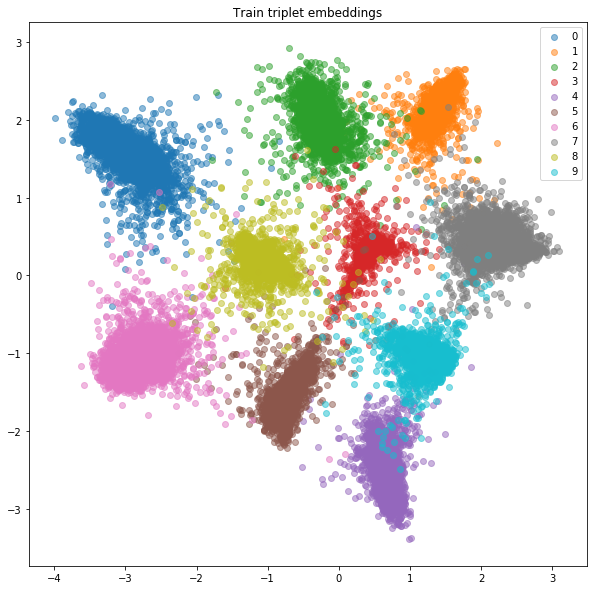

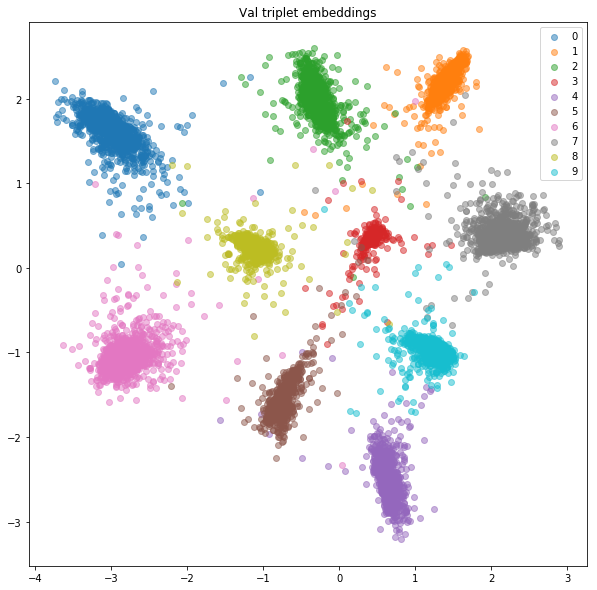

In [29]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model, args)
plot_embeddings(train_embeddings_tl, train_labels_tl, title='Train triplet embeddings')
test_embeddings_tl, test_labels_tl = extract_embeddings(test_loader, model, args)
plot_embeddings(test_embeddings_tl, test_labels_tl, title='Val triplet embeddings')

In [30]:
# L2-normalize embeddings
test_embeddings_tl_norm = test_embeddings_tl / np.linalg.norm(test_embeddings_tl, axis=-1, keepdims=True)

In [31]:
test_images_raw = get_raw_images(test_loader)

query_id: 4288 | query_embedding: [0.71576928 0.69833684]


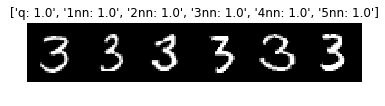

query_id: 5428 | query_embedding: [-0.86428989  0.50299402]


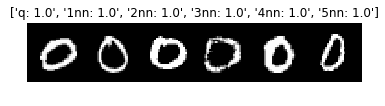

query_id: 8121 | query_embedding: [ 0.2257078  -0.97419505]


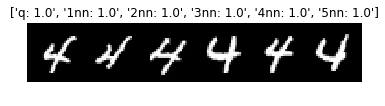

query_id: 3000 | query_embedding: [-0.92847891 -0.37138514]


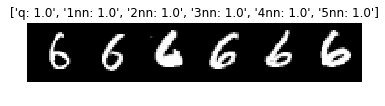

query_id: 7383 | query_embedding: [-0.97712365  0.21267198]


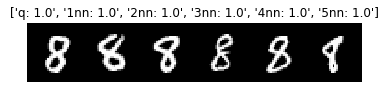

In [40]:
for i in range(5):
    launch_query(test_embeddings_tl_norm, test_images_raw)

# 5. Online pair selection - negative mining
There are couple of problems with siamese (and triplet) networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs compared to 80 pairs in previous implementation.


## 5.1 Online pair selection

In [51]:
class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples num_classes and within these classes samples num_samples.
    Returns batches of size num_classes * num_samples
    """

    def __init__(self, dataset, num_classes, num_samples):
        if dataset.train:
            self.labels = dataset.train_labels
        else:
            self.labels = dataset.test_labels
            
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
            
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.num_classes = num_classes
        self.num_samples = num_samples
        self.dataset = dataset
        self.batch_size = self.num_samples * self.num_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < len(self.dataset):
            classes = np.random.choice(self.labels_set, self.num_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.num_samples])
                self.used_label_indices_count[class_] += self.num_samples
                if self.used_label_indices_count[class_] + self.num_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.num_classes * self.num_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size

## 5.2 Online pair selection

In [52]:
from itertools import combinations

def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix


class HardNegativePairSelector():
    """
    Creates all possible positive pairs. For negative pairs, pairs with smallest distance are taken into consideration,
    matching the number of positive pairs.
    """

    def __init__(self, cpu=True):
#         super(HardNegativePairSelector, self).__init__()
        self.cpu = cpu

    def get_pairs(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
            
        distance_matrix = pdist(embeddings)

        labels = labels.cpu().data.numpy()
        all_pairs = np.array(list(combinations(range(len(labels)), 2)))
        all_pairs = torch.LongTensor(all_pairs)
        positive_pairs = all_pairs[(labels[all_pairs[:, 0]] == labels[all_pairs[:, 1]]).nonzero()]
        negative_pairs = all_pairs[(labels[all_pairs[:, 0]] != labels[all_pairs[:, 1]]).nonzero()]

        negative_distances = distance_matrix[negative_pairs[:, 0], negative_pairs[:, 1]]
        negative_distances = negative_distances.cpu().data.numpy()
        top_negatives = np.argpartition(negative_distances, len(positive_pairs))[:len(positive_pairs)]
        top_negative_pairs = negative_pairs[torch.LongTensor(top_negatives)]

        return positive_pairs, top_negative_pairs

# 5.3 Online contrastive loss

In [53]:
class OnlineContrastiveLoss(nn.Module):
    """
    Online Contrastive loss
    Takes a batch of embeddings and corresponding labels.
    Pairs are generated using pair_selector object that take embeddings and targets and return indices of positive
    and negative pairs
    """

    def __init__(self, margin, pair_selector):
        super(OnlineContrastiveLoss, self).__init__()
        self.margin = margin
        self.pair_selector = pair_selector

    def forward(self, embeddings, target):
        positive_pairs, negative_pairs = self.pair_selector.get_pairs(embeddings, target)
        if embeddings.is_cuda:
            positive_pairs = positive_pairs.cuda()
            negative_pairs = negative_pairs.cuda()
        positive_loss = (embeddings[positive_pairs[:, 0]] - embeddings[positive_pairs[:, 1]]).pow(2).sum(1)
        negative_loss = F.relu(
            self.margin - (embeddings[negative_pairs[:, 0]] - embeddings[negative_pairs[:, 1]]).pow(2).sum(
                1).sqrt()).pow(2)
        loss = torch.cat([positive_loss, negative_loss], dim=0)
        return loss.mean()


# 5.4 Training

In [54]:
# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class

train_batch_sampler = BalancedBatchSampler(train_dataset, num_classes=args.num_classes, num_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, num_classes=args.num_classes, num_samples=25)

kwargs = {'num_workers': args.num_workers, 'pin_memory': True} 
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())

model.to(args.device)
loss_fn.to(args.device)

args.lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)


In [55]:
def train_mining_epoch(train_loader, model, loss_fn, optimizer, args, log_interval=50):
    model.train()
    losses = []
    total_loss, num_samples =  0, 0
  
    for batch_idx, (data, target) in enumerate(train_loader):
        num_samples += data[0].size(0)
        
        if not type(data) in (tuple, list):
            data = (data,)
            
        data = tuple(d.to(args.device) for d in data)
        target = target.to(args.device)
          
        optimizer.zero_grad()
        
        outputs = model(*data)
        
        loss = loss_fn(outputs, target)
        
        losses.append(loss.data.item())

        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses)))           
            
            total_loss += np.sum(losses)
            losses = []
            
    return total_loss/(batch_idx + 1)

def test_mining_epoch(test_loader, model, loss_fn, args, log_interval=50):
    with torch.no_grad():
        model.eval()
        losses = []
        num_samples = 0
    
        for batch_idx, (data, target) in enumerate(test_loader):

            if not type(data) in (tuple, list):
                data = (data,)
                
            data = tuple(d.to(args.device) for d in data)
            target = target.to(args.device)
            outputs = model(*data)

            loss = loss_fn(outputs, target)
            losses.append(loss.data.item())
    
        return np.sum(losses)/(batch_idx + 1)

In [56]:
args.start_epoch = 0

# needed for annealing learning rate in case of resuming of training
for epoch in range(0, args.start_epoch):
    scheduler.step()

# main training loop
for epoch in range(args.start_epoch, args.num_epochs):
    scheduler.step()

    # train stage
    train_loss = train_mining_epoch(online_train_loader, model, loss_fn, optimizer, args)
    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(
        epoch + 1, args.num_epochs, train_loss)
    
    # testing/validation stage    
    test_loss = test_mining_epoch(online_test_loader, model, loss_fn, args)
    
    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, args.num_epochs,
                                                                             test_loss)
    print(message)

Train: [0/60000 (0%)]	Loss: 0.496822 
Train: [12500/60000 (21%)]	Loss: 0.386797 
Train: [25000/60000 (42%)]	Loss: 0.269799 
Train: [37500/60000 (62%)]	Loss: 0.221043 
Train: [50000/60000 (83%)]	Loss: 0.194115 
Epoch: 1/10. Train set: Average loss: 0.2263
Epoch: 1/10. Validation set: Average loss: 0.1612
Train: [0/60000 (0%)]	Loss: 0.198582 
Train: [12500/60000 (21%)]	Loss: 0.159672 
Train: [25000/60000 (42%)]	Loss: 0.146273 
Train: [37500/60000 (62%)]	Loss: 0.136937 
Train: [50000/60000 (83%)]	Loss: 0.123992 
Epoch: 2/10. Train set: Average loss: 0.1194
Epoch: 2/10. Validation set: Average loss: 0.1148
Train: [0/60000 (0%)]	Loss: 0.099329 
Train: [12500/60000 (21%)]	Loss: 0.102162 
Train: [25000/60000 (42%)]	Loss: 0.097239 
Train: [37500/60000 (62%)]	Loss: 0.095003 
Train: [50000/60000 (83%)]	Loss: 0.087368 
Epoch: 3/10. Train set: Average loss: 0.0803
Epoch: 3/10. Validation set: Average loss: 0.0711
Train: [0/60000 (0%)]	Loss: 0.042948 
Train: [12500/60000 (21%)]	Loss: 0.062688 
Trai

## 5.5 Visualizations

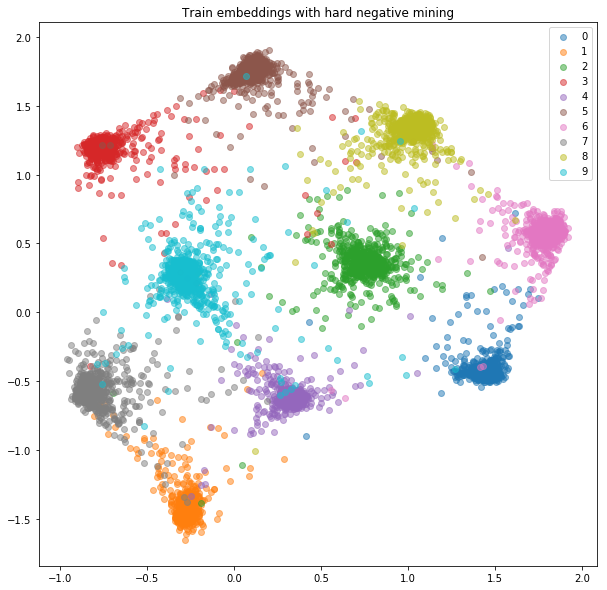

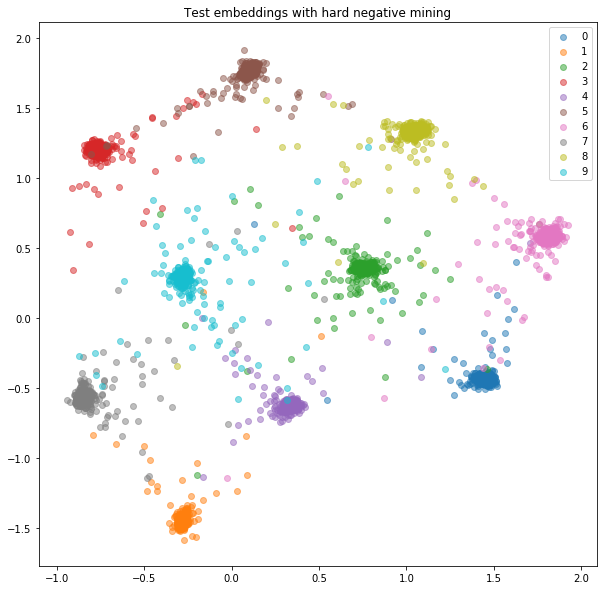

In [57]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model, args)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, title='Train embeddings with hard negative mining')
test_embeddings_ocl, test_labels_ocl = extract_embeddings(test_loader, model, args)
plot_embeddings(test_embeddings_ocl, test_labels_ocl, title='Test embeddings with hard negative mining')

In [ ]:
# L2-normalize embeddings
test_embeddings_ocl_norm = test_embeddings_ocl / np.linalg.norm(test_embeddings_ocl, axis=-1, keepdims=True)

In [ ]:
test_images_raw = get_raw_images(test_loader)

In [ ]:
for i in range(5):
    launch_query(test_embeddings_ocl_norm, test_images_raw)